In [13]:
from tqdm import tqdm
from baselines import ValueDirected, ThompsonSampling, UCB
from utils import load_csv
import torch
import numpy as np
import math

import matplotlib.pyplot as plt
import seaborn as sns

In [22]:
ts = ThompsonSampling()
ucb = UCB()
mean_var = 100
reward_var = 10

model_samples = 100
num_models = 10
eps = 1 / 1000

current_data = load_csv('data/data2.csv')
likelihood_ucbts = np.zeros((len(current_data), 2))

# for each subject
for subject in tqdm(range(len(current_data))):
    
    # for each N
    for n in range(2):           
        # for each step
        for i in range(current_data[0, subject]['c'].shape[0]):

            # reset in first step
            if not (i % 10):
                priors = np.zeros((2, 2))
                priors[:, 1] = mean_var
                obs = torch.zeros(1, 2)
            else:
                obs[0, 0] = current_data[0, subject]['r'][i-1]
                obs[0, 1] = float(current_data[0, subject]['c'][i-1, 0]) - 1
            
            action = float(current_data[0, subject]['c'][i, 0]) - 1 
            reward = current_data[0, subject]['r'][i]
                           
            
            if n == 0:
                action_ts = ts.act(priors)
                action_ts = min(max(action_ts, eps), 1-eps)
                likelihood_ucbts[subject, 0] += action * math.log(action_ts) + (1 - action) * math.log(1 - action_ts)
                
                alpha = (priors[int(action), 1]) / (priors[int(action), 1] + reward_var)
                priors[int(action), 0] = priors[int(action), 0] + alpha * (reward - priors[int(action), 0])
                priors[int(action), 1] = priors[int(action), 1] - alpha * priors[int(action), 1]
        
            elif n == 1:
                action_ucb = ucb.act(priors)
                action_ucb = min(max(action_ucb, eps), 1-eps)
                likelihood_ucbts[subject, 1] += action * math.log(action_ucb) + (1 - action) * math.log(1 - action_ucb)
                
                alpha = (priors[int(action), 1]) / (priors[int(action), 1] + reward_var)
                priors[int(action), 0] = priors[int(action), 0] + alpha * (reward - priors[int(action), 0])
                priors[int(action), 1] = priors[int(action), 1] - alpha * priors[int(action), 1]
                
        
np.save('data/likelihood_ucbts.npy', likelihood_ucbts)    

100%|██████████| 44/44 [00:00<00:00, 169.09it/s]

[[ -91.5393702  -179.47007138]
 [ -59.09533174  -74.1231912 ]
 [ -65.70023195  -65.43616182]
 [ -60.99078734  -67.00861818]
 [ -61.23017384  -75.68881396]
 [ -69.65063379  -94.93927274]
 [ -67.24991155 -105.07617323]
 [ -85.62623309 -134.0038768 ]
 [ -67.74363469  -95.47613677]
 [ -54.3816047   -56.53567642]
 [ -92.59346822 -374.88334235]
 [ -53.28215111  -51.97529703]
 [ -78.24717577  -85.82919387]
 [ -77.24183003 -258.0286787 ]
 [ -60.10660294  -77.02023685]
 [ -78.74432632  -98.50447556]
 [ -61.79525469  -73.77795853]
 [ -86.37295006 -115.9561458 ]
 [-112.47978068 -163.81313848]
 [ -63.83806798  -75.08171636]
 [ -63.38518991  -67.95398996]
 [ -90.79800968  -93.18438838]
 [ -83.66010355  -82.25329414]
 [ -71.83741345 -232.88387753]
 [ -60.09595536 -348.52674747]
 [ -65.90971853 -104.07211912]
 [-118.40376136 -209.00954066]
 [ -77.42798355 -117.3280979 ]
 [ -87.96100948 -127.98806898]
 [ -83.10352307 -103.56737522]
 [ -94.04367763 -136.42962445]
 [ -89.02053912 -317.40096249]
 [ -84.0

In [2]:
vd = ValueDirected()
mean_var = 100
reward_var = 10

policies = [256, 512, 1024, 2048, 4096, 8192] 

model_samples = 100
num_models = 10
eps = 1 / (model_samples * num_models)

current_data = load_csv('data/data2.csv')
likelihood_human = np.zeros((len(current_data), len(policies) + 1))

# for each subject
for subject in tqdm(range(len(current_data))):
    
    # for each N
    for n, policy in enumerate(policies):
        load_paths = ['trained_models/models_0911/' + str(policy) + '/' + str(i+1) + '_0.pt' for i in range(num_models)]
        models = [] 
        for load_path in load_paths:
            N, t, model = torch.load(load_path)
            models.append(model)
            
        # for each step
        for i in range(current_data[0, subject]['c'].shape[0]):

            # reset in first step
            if not (i % 10):
                if n == 0:
                    priors = np.zeros((2, 2))
                    priors[:, 1] = mean_var
                hxs = []
                zetas = []
                for model in range(num_models):
                    hx = [models[model].initial_states(1) for k in range(model_samples)]
                    zeta = [models[model].get_zeta(1) for k in range(model_samples)]
                    hxs.append(hx)
                    zetas.append(zeta)
                obs = torch.zeros(1, 2)
            else:
                obs[0, 0] = current_data[0, subject]['r'][i-1]
                obs[0, 1] = float(current_data[0, subject]['c'][i-1, 0]) - 1 
            
            action_model = 0
            for model in range(num_models):
                for sample in range(model_samples):
                    q_mu, _, hxs[model][sample] = models[model](obs, hxs[model][sample], zetas[model][sample])
                    action_model += torch.argmax(q_mu[0]).float().item()
                    
 
            action_model = action_model / (model_samples * num_models)
            action_model = min(max(action_model, eps), 1-eps)
            
            action = float(current_data[0, subject]['c'][i, 0]) - 1
            reward = current_data[0, subject]['r'][i]
                           
            
            if n == 0:
                action_vd = vd.act(priors)
                action_vd = min(max(action_vd, eps), 1-eps)
                likelihood_human[subject, -1] += action * math.log(action_vd) + (1 - action) * math.log(1 - action_vd)
                
                alpha = (priors[int(action), 1]) / (priors[int(action), 1] + reward_var)
                priors[int(action), 0] = priors[int(action), 0] + alpha * (reward - priors[int(action), 0])
                priors[int(action), 1] = priors[int(action), 1] - alpha * priors[int(action), 1]
        
            likelihood_human[subject, n] += action * math.log(action_model) + (1 - action) * math.log(1 - action_model)
        
np.save('data/likelihood_human.npy', likelihood_human)    
    

  0%|          | 0/44 [00:00<?, ?it/s]/home/marcel/anaconda3/envs/py36/lib/python3.6/site-packages/torch/serialization.py:367: SourceChangeWarning: source code of class 'models.mdlrdqn.MDLRDQN' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)
/home/marcel/anaconda3/envs/py36/lib/python3.6/site-packages/torch/serialization.py:367: SourceChangeWarning: source code of class 'models.linear.LinearGroupHS' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)
/home/marcel/anaconda3/envs/py36/lib/python3.6/site-packages/torch/serialization.py:367: SourceChangeWarning: source code of class 'models.recurrent.GroupHSGRUCell' has changed. you c

[4 4 1 1 4 4 5 2 4 4 2 4 5 2 1 1 4 4 2 4 1 4 2 4 5 4 2 4 4 2 2 4 1 2 4 1 5
 4 4 1 4 5 5 4]


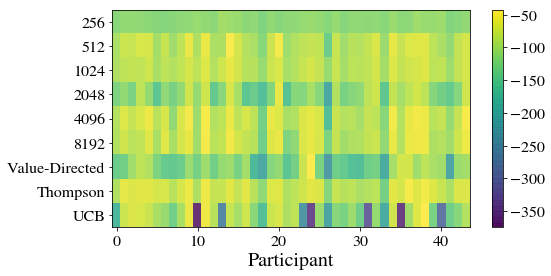

72.82237027214069
5391.360389564932


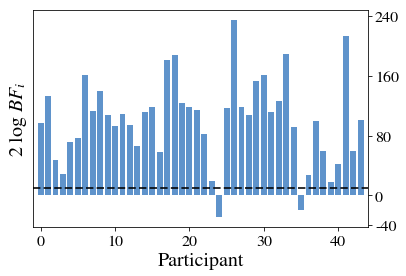

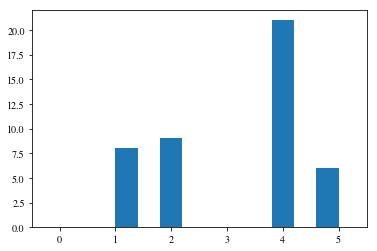

In [51]:
from scipy.special import logsumexp

plt.rcParams["figure.figsize"] = (8.0, 4.0)
plt.rcParams['mathtext.fontset'] = 'stix'
plt.rcParams['font.family'] = 'STIXGeneral'

likelihood_human = np.load('data/likelihood_human.npy')
likelihood_ucbts = np.load('data/likelihood_ucbts.npy')

likelihood_all = np.concatenate((likelihood_human, likelihood_ucbts), axis=1)

plt.imshow(likelihood_all.T, aspect='auto', alpha=0.8)
cb = plt.colorbar()
cb.ax.set_yticklabels(cb.ax.get_yticklabels(), fontsize=16)
plt.xticks([0, 10, 20, 30, 40],[0, 10, 20, 30, 40], fontsize=16 )
plt.xlabel('Participant', fontsize=20)
best_model = np.argmax(likelihood_human[:, :len(policies)].T, axis=0)
print(best_model)
max_entries = np.zeros_like(likelihood_human)
for i in range(max_entries.shape[0]):
    max_entries[i, best_model[i]] = 1
plt.yticks([0, 1, 2, 3, 4, 5, 6, 7, 8], policies + ['Value-Directed'] + ['Thompson'] + ['UCB'],  fontsize=16)


plt.savefig('comparison.pdf', bbox_inches='tight')
plt.show()

plt.rcParams["figure.figsize"] = (6.0, 4.0)
plt.rcParams['mathtext.fontset'] = 'stix'
plt.rcParams['font.family'] = 'STIXGeneral'

plt.rcParams["figure.figsize"] = (6.0, 4.0)
plt.rcParams['mathtext.fontset'] = 'stix'
plt.rcParams['font.family'] = 'STIXGeneral'

logAVGK = np.log(np.mean(np.exp(likelihood_human[:, :6]), 1)) - np.log(np.exp(likelihood_human[:, -1]))

print(2 * (np.sum(np.log(1/6) + logsumexp(likelihood_human[:, :6], axis=1)) - np.sum(likelihood_ucbts[:, 0])))
print(2 * (np.sum(np.log(1/6) + logsumexp(likelihood_human[:, :6], axis=1)) - np.sum(likelihood_ucbts[:, 1])))

plt.bar(np.arange(logAVGK.shape[0]), 2*logAVGK, alpha=0.8, color=sns.xkcd_rgb["windows blue"])
plt.tick_params(axis='y', which='both', labelleft='off', labelright='on', right='on', left='off')
plt.xlim(-1, logAVGK.shape[0])
plt.xlabel('Participant', fontsize=20)
plt.ylabel(r'$2 \  \log \ BF_i$', fontsize=20)
plt.xticks([0, 10, 20, 30, 40],[0, 10, 20, 30, 40], fontsize=16 )
plt.yticks([-40, 0, 80, 160, 240], [-40, 0, 80, 160, 240], fontsize=16)
plt.axhline(y=10, linestyle="--", color='black', alpha=0.8, linewidth=2)
plt.savefig('comparison3.pdf', bbox_inches='tight')
plt.show()

plt.hist(best_model)
plt.xlim(-0.5, 5.5)
plt.show()